In [33]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv('GROQ_API_KEY')
LLM=ChatGroq(model='llama-3.1-8b-instant',api_key=groq_api_key)

python-dotenv could not parse statement starting at line 2


In [34]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
#Import wrapper
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [35]:
api_wrapper_wiki=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_wiki)
arxiv.invoke("attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [36]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.invoke("what is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [37]:
TRAVILY_API_KEY=os.getenv('TRAVILY_API_KEY')

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults(api_key=TRAVILY_API_KEY)
tavily.invoke("What is the capital of France?")

[{'title': 'Capital of France | Paris Travel Guide, Facts & Highlights',
  'url': 'https://simcorner.com/blogs/travel-guides/capital-of-france',
  'content': 'Paris serves as the capital of France and the center of modern governance, home to the President at the Élysée Palace, the Prime Minister at the Hôtel Matignon, and Parliament’s two chambers. This proximity supports efficient policy-making under France’s semi-presidential system. International institutions such as UNESCO and the OECD enhance Paris’s diplomatic influence. [...] Paris is the capital of France, a major European city where history, culture, and modern life meet along the Seine River. The city combines iconic landmarks like the Eiffel Tower and the Louvre Museum with bustling boulevards, gourmet bistros, and lively markets. As the political hub, housing the French President at the Élysée Palace and the National Assembly, Paris also offers a rich cultural experience through museums, theaters, and fashion districts. It 

In [39]:
#combine all tools
tools=[arxiv,wiki,tavily]
llm_with_tools=LLM.bind_tools(tools)

In [40]:
#add Nodes and edges
from langchain_core.messages import AnyMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content="What is the tody's Tesla stock price?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'aah4tnsn8', 'function': {'arguments': '{"query":"Tesla stock price today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 557, 'total_tokens': 578, 'completion_time': 0.040669436, 'completion_tokens_details': None, 'prompt_time': 0.04738499, 'prompt_tokens_details': None, 'queue_time': 0.04514889, 'total_time': 0.088054426}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c420c-8292-7dc2-ab72-8dc2e456b0f0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Tesla stock price today'}, 'id': 'aah4tnsn8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 557, 'output_tokens': 21, 'total_tokens': 578})

In [41]:
from typing_extensions import TypedDict
from typing import List,Annotated
from langchain_core.messages import AnyMessage,HumanMessage
from langgraph.graph.message import add_messages

class TypeDictClass(TypedDict):
    messages:Annotated[list, add_messages]

In [42]:
from langgraph.graph import StateGraph
builder=StateGraph(TypeDictClass)

In [43]:
def llm_with_tools_func(state):
    return {"messages":llm_with_tools.invoke(state["messages"])}

In [44]:
from langgraph.prebuilt import ToolNode
builder.add_node("llm_with_tools_func", llm_with_tools_func)
builder.add_node("tools", ToolNode(tools))

In [45]:
from langgraph.graph import START,END
from langgraph.prebuilt import tools_condition 
builder.add_edge(START, "llm_with_tools_func")
builder.add_conditional_edges(
    "llm_with_tools_func",
    tools_condition
)
builder.add_edge("tools", END)

In [46]:
graph_=builder.compile()

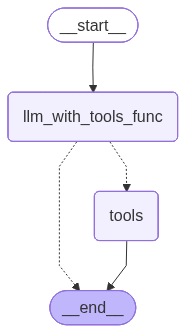

In [47]:
graph_

In [51]:
response=graph_.invoke({"messages":[HumanMessage(content="what is tesla today's price?")]})
response

{'messages': [HumanMessage(content="what is tesla today's price?", additional_kwargs={}, response_metadata={}, id='366d9238-b45c-4a12-80ab-7f0ef4832b16'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9sk3gn14c', 'function': {'arguments': '{"query":"tesla stock price today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 555, 'total_tokens': 577, 'completion_time': 0.025819156, 'completion_tokens_details': None, 'prompt_time': 0.189668515, 'prompt_tokens_details': None, 'queue_time': 0.074762285, 'total_time': 0.215487671}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c420e-fe5d-7113-8ba5-aa208995078d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'tesla stock price today'}, 'id': '9sk3gn14c', 'type

In [53]:
for n in response["messages"]:
    n.pretty_print()

================================ Human Message =================================

what is tesla today's price?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9sk3gn14c)
 Call ID: 9sk3gn14c
  Args:
    query: tesla stock price today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Tesla: TSLA Stock Price Quote & News | Robinhood", "url": "https://robinhood.com/us/en/stocks/TSLA/", "content": "# Tesla\n\n#### Trade Tesla 24 hours a day, five days a week on Robinhood.\n\n## About TSLA\n\n### Tesla, Inc. engages in the design, development, manufacture, and sale of electric vehicles and energy generation and storage systems. It operates through the Automotive and Energy Generation and Storage segments. Show more\n\n## TSLA Key Statistics\n\n## Stock Snapshot\n\nThe current Tesla(TSLA) stock price is $409.54, with a market capitalization of